<a href="https://colab.research.google.com/github/CastHash532/Best-Flutter-UI-Templates/blob/master/Notebooks/kaggle_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [ ]:
!pip install flaml[notebook];

## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


## Load data and preprocess



In [2]:
!kaggle competitions download -c digit-recognizer
#!kaggle datasets download -d repo

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!ls

sample_data	       test.csv      train.csv
sample_submission.csv  test.csv.zip  train.csv.zip


In [4]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               


In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

ds_train = pd.read_csv('train.csv')
ds_test = pd.read_csv('test.csv')

X_train = ds_train.drop('label',axis=1)
y_train = ds_train['label']
X_test= ds_test

## Autokeras

In [6]:
import autokeras as ak

In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(X_train, y_train, epochs=10)

In [ ]:
# Predict with the best model.
predicted_y = clf.predict(X_test)
print(predicted_y)

In [ ]:
# Evaluate the best model with testing data.
print(clf.evaluate(X_test, y_test))

## Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [19]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [20]:
settings = {
    "time_budget": 180,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [21]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 09-19 16:43:40] {1427} INFO - Evaluation method: holdout
[flaml.automl: 09-19 16:43:40] {1473} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-19 16:43:40] {1505} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 09-19 16:43:40] {1735} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-19 16:43:46] {1920} INFO -  at 39.6s,	best lgbm's error=0.2269,	best lgbm's error=0.2269
[flaml.automl: 09-19 16:43:46] {1735} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-19 16:43:53] {1920} INFO -  at 46.4s,	best lgbm's error=0.2269,	best lgbm's error=0.2269
[flaml.automl: 09-19 16:43:53] {1735} INFO - iteration 2, current learner lgbm
[flaml.automl: 09-19 16:43:59] {1920} INFO -  at 52.4s,	best lgbm's error=0.2065,	best lgbm's error=0.2065
[flaml.automl: 09-19 16:43:59] {1735} INFO - iteration 3, current learner xgboost
[flaml.automl: 09-19 16:44:16] {1920} INFO -  at 69.4s,	best xgboos

#### Best model and metric

In [22]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 14, 'num_leaves': 5, 'min_child_samples': 5, 'learning_rate': 0.7590459488450945, 'log_max_bin': 8, 'colsample_bytree': 0.8304072431299575, 'reg_alpha': 0.001951378031519758, 'reg_lambda': 0.04792552866398477}
Best accuracy on validation data: 0.8831
Training duration of best run: 13.32 s


In [23]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.8304072431299575,
               learning_rate=0.7590459488450945, max_bin=128,
               min_child_samples=5, n_estimators=14, num_leaves=5,
               objective='multiclass', reg_alpha=0.001951378031519758,
               reg_lambda=0.04792552866398477, verbose=-1)

In [24]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [2 0 9 ... 3 9 2]


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

#### Log history

In [26]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 37801, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 37801, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.001348364934537134, 'reg_lambda': 1.4442580148221913}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg

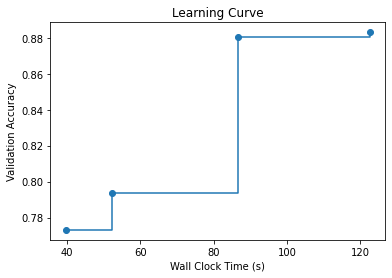

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## Submit results to Kaggle

In [29]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [49]:
submission = pd.DataFrame (
    {'label':y_pred},
    
)
submission.index.name= 'ImageId'
submission.index += 1
submission.to_csv('/content/submission.csv')

In [50]:
submission

,label
ImageId,
1,2
2,0
3,9
4,4
5,2
...,...
27996,9
27997,7
27998,3


In [51]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Flaml AutoML"

100% 208k/208k [00:01<00:00, 175kB/s]
Successfully submitted to Digit Recognizer